# A/B-тесты

## Задача 3. A/B-тест. **Метрика линеаризации**

Вместо того, чтобы использовать "поюзерные" CTR для тестирования, мы можем создать альтернативную метрику, которая будет гарантировать, что если этот тест выявит изменения, то они также будут отображены в исходной метрике (такой как лайки на пользователя и пользовательский CTR).

Метрика считается следующим образом:

1) Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
2) Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
3) Проводим t-тест для сравнения различий между группами по этой новой метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  

Задача:

1) Анализируем тест между группами 0 и 3 по метрике линеаризованных лайков. Видим ли отличия? Уменьшилось ли p-value по сравнению с обычным CTR?
2) Анализируем тест между группами 1 и 2 по метрике линеаризованных лайков. Видим ли отличия? Уменьшилось ли p-value по сравнению с обычным CTR?

In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import matplotlib as mpl
from scipy import stats

In [9]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20231020',
'user':'student',
'password':'dpo_python_2020'
}

## Тест 0, 3

In [10]:
query1 = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-09-28' and '2023-10-04'
    and exp_group in (0,3)
GROUP BY exp_group, user_id
"""

In [11]:
df03 = ph.read_clickhouse(query1, connection=connection)

In [12]:
df03.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,12,44,0.272727
1,3,123580,2,11,0.181818
2,0,4944,8,41,0.195122
3,0,4504,5,15,0.333333
4,0,121508,6,25,0.240000


Посчитаем в контрольной группе (0) деление лайков на просмотры:

In [13]:
ctr_control0 = df03[df03['exp_group'] == 0].likes.sum() / df03[df03['exp_group'] == 0].views.sum()

In [14]:
df03['linearized_likes'] = df03['likes'] - ctr_control0 * df03['views']

In [15]:
df03.head()

,exp_group,user_id,likes,views,ctr,linearized_likes
0,3,115383,12,44,0.272727,2.767128
1,3,123580,2,11,0.181818,-0.308218
2,0,4944,8,41,0.195122,-0.603358
3,0,4504,5,15,0.333333,1.852430
4,0,121508,6,25,0.240000,0.754050


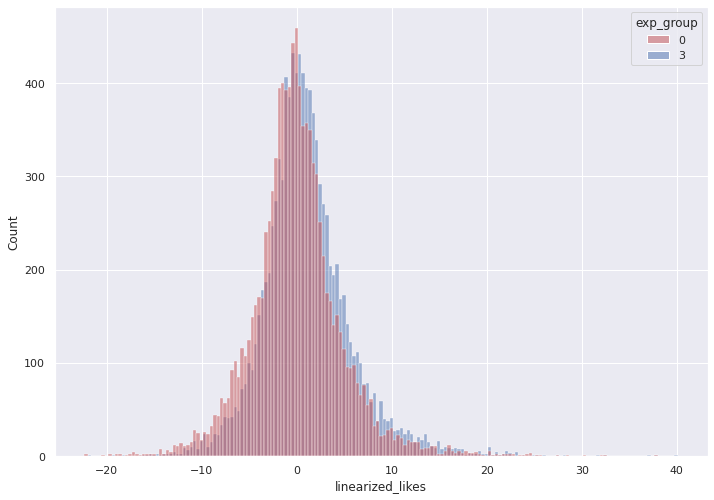

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = df03,
                     x = 'linearized_likes',
                     hue = 'exp_group',
                     palette = ['r','b'],
                     alpha = 0.5,
                     kde = False)

Применим t-тест Стьюдента по обычной метрике ctr:

In [22]:
stats.ttest_ind(df03[df03.exp_group == 0].ctr,
                df03[df03.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.935320516755773, pvalue=6.216047483062228e-44)

Теперь применим t-тест Стьюдента по линеаризованным лайкам:

In [23]:
stats.ttest_ind(df03[df03.exp_group == 0].linearized_likes,
                df03[df03.exp_group == 3].linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=-16.186230032932844, pvalue=1.4918137745326139e-58)

### **Вывод**

Оба проведенных t-теста Стьюдента показали статистически значимые различия между группами 0 и 3. Кроме того, по метрике линеаризованных лайков p value стало значительнее меньше чем по метрике ctr.

## Тест 1, 2

In [27]:
query2 = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-09-28' and '2023-10-04'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

In [29]:
df12 = ph.read_clickhouse(query2, connection=connection)

In [30]:
df12.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,18392,7,32,0.218750
4,1,26295,39,141,0.276596


Посчитаем в контрольной группе (1) деление лайков на просмотры:

In [33]:
ctr_control1 = df12[df12['exp_group'] == 1].likes.sum() / df12[df12['exp_group'] == 1].views.sum()

In [34]:
df12['linearized_likes'] = df12['likes'] - ctr_control1 * df12['views']

In [36]:
df12.head()

,exp_group,user_id,likes,views,ctr,linearized_likes
0,1,109963,3,15,0.200000,-0.144062
1,1,26117,32,141,0.226950,2.445813
2,1,138232,18,73,0.246575,2.698896
3,1,18392,7,32,0.218750,0.292667
4,1,26295,39,141,0.276596,9.445813


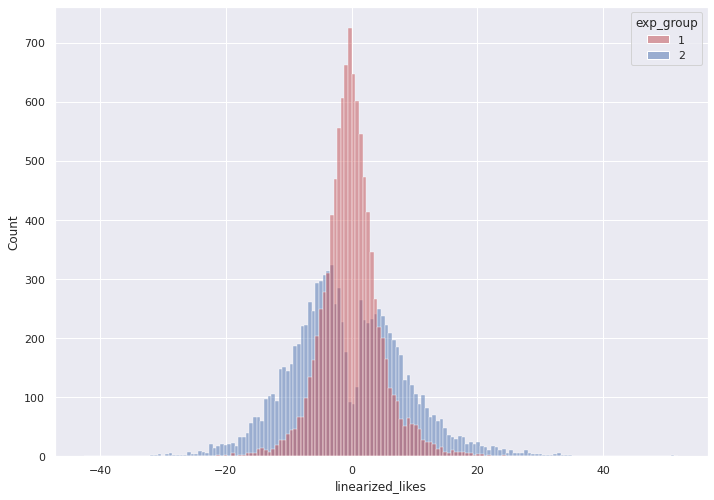

In [37]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups1 = sns.histplot(data = df12,
                     x = 'linearized_likes',
                     hue = 'exp_group',
                     palette = ['r','b'],
                     alpha = 0.5,
                     kde = False)

Применим t-тест Стьюдента по обычной метрике ctr:

In [38]:
stats.ttest_ind(df12[df12.exp_group == 1].ctr,
                df12[df12.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

Теперь применим t-тест Стьюдента по линеаризованным лайкам:

In [39]:
stats.ttest_ind(df12[df12.exp_group == 1].linearized_likes,
                df12[df12.exp_group == 2].linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=5.936377101934482, pvalue=2.9805064038667734e-09)

### **Вывод**

T-test по метрике ctr не вывел различий между группами 1 и 2, в то время как t-тест по метрике линеаризованных лайков показал значимое различие между группами с p value < 0.05 и гораздо меньшим значением чем в случае с ctr.